<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/main/Single_Asset_Converge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate Sample Paths

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [3]:
def SimPaths(S0, kappa, theta, sigma, T, Ndt, Nsims):
    
    # time grid
    t = np.linspace(0, T, Ndt+1)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)

    # effective vol for large time steps
    #   sigma_eff = sigma *sqrt( (1-exp(-2*kappa*dt)) / (2*kappa) )
    #             ~ sigma *sqrt(  ( 1 - (1-2*kappa*dt + ..) ) /(2 *kappa) )
    #             ~ sigma *sqrt(  dt )
    sigma_eff = sigma * np.sqrt( (1-np.exp(-2*kappa*dt)) / (2*kappa))

    # store the sample paths
    X = np.zeros((Nsims, Ndt+1))
    Y = np.zeros((Nsims, Ndt+1))
    Z = np.zeros((Nsims, Ndt+1))

    X[:,0] = S0[0]
    Y[:,0] = S0[1]
    Z[:,0] = S0[2]


    for i in range(Ndt):

#         # Euler discretization of the SDE
#         #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
#         dW_x = sqrt_dt * np.random.randn(Nsims)
#         X[:,i+1] = X[:,i]  + kappa[0] * (theta[0] - X[:,i]) * dt + sigma[0] * dW_x

#         # Euler discretization of the SDE
#         #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
#         dW_y = sqrt_dt * np.random.randn(Nsims)
#         Y[:,i+1] = Y[:,i] + kappa[1] * (theta[1] - Y[:,i]) * dt + sigma[1] * dW_y

        # Exact solution to the SDE
        #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
        N_x =  np.random.randn(Nsims)
        X[:,i+1] = theta[0] + (X[:,i]-theta[0])*np.exp(-kappa[0]*dt) + sigma_eff[0] * N_x
        
        # Euler discretization of the SDE
        #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
        N_y = np.random.randn(Nsims)
        Y[:,i+1] = theta[1] + (Y[:,i]-theta[1])*np.exp(-kappa[1]*dt) + sigma_eff[1] * N_y

        # update Z according to no-arbitrage
        Z[:,i+1] = 1.0/(X[:,i+1]*Y[:,i+1])
        
    return t, X, Y, Z

In [4]:
# model paramteres on hourly time scales
kappa = np.array([2, 2])
theta = np.array([1, 1.1])
sigma = np.array([1, 1])*1e-3

# initial values of the FX rates
X0 = 1.000
Y0 = 1.1 #1.0995
Z0 = 1.0/(X0*Y0)

T = 1 # in minutes
Ndt = 600 # in miliseconds

Nsims = 10000 # number of sims

t, X, Y, Z = SimPaths([X0, Y0, Z0], kappa, theta, sigma, T, Ndt, Nsims)

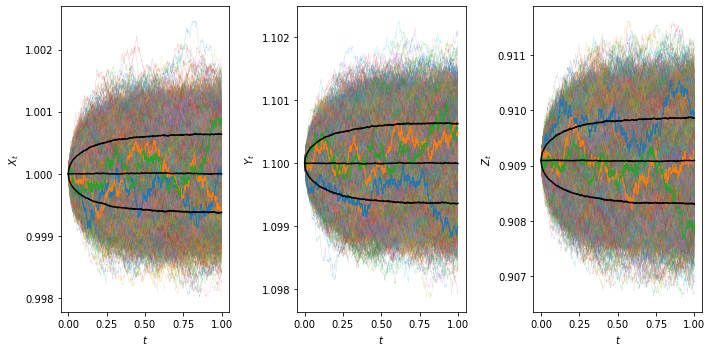

In [7]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, X.T, linewidth=0.1)
plt.plot(t, X[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(X,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$X_t$')

plt.subplot(1,3,2)
plt.plot(t, Y.T, linewidth=0.1)
plt.plot(t, Y[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Y,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Y_t$')

plt.subplot(1,3,3)
plt.plot(t, Z.T, linewidth=0.1)
plt.plot(t, Z[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Z,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Z_t$')

fig.tight_layout()

plt.show()

In [8]:
import pandas as pd
data = {'Time': t, 
        'X': X[0],
        'Y' : Y[0],
        'Z': Z[0]}
  
# Convert the dictionary into DataFrame 
data = pd.DataFrame(data) 
print(data)

         Time         X         Y         Z
0    0.000000  1.000000  1.100000  0.909091
1    0.001667  0.999984  1.099964  0.909136
2    0.003333  0.999964  1.099946  0.909168
3    0.005000  0.999918  1.099923  0.909230
4    0.006667  0.999948  1.099912  0.909212
..        ...       ...       ...       ...
596  0.993333  1.000103  1.098866  0.909936
597  0.995000  1.000048  1.098967  0.909902
598  0.996667  1.000000  1.098979  0.909935
599  0.998333  0.999965  1.098972  0.909973
600  1.000000  0.999978  1.098989  0.909947

[601 rows x 4 columns]


In [9]:
# train_test_split = 0.5
# train = data[:int(train_test_split*len(data))]
# test = data[int(train_test_split*len(data)):]

#State: 
>$S_t=(X_t, P_t) $

where X is inventory and P is price

#Action: 
>$a_t = \{Buy, Sell, Hold\} $

#State Evolution
>$X_{t+1}= X_t + a_t $

>$P_{t+1}= f(P_t) + \epsilon $

In [18]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0

        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if len(self.positions)>=20:
              reward = -1
            else:
              self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        if len(self.positions)>=10:
          reward = -1
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
            #self.positions = []
            #act = 2   #Force selling at end of period


        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        actual_action = act
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [19]:
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)

In [22]:
hidden_size=100
input_size=91
output_size=3
USE_CUDA = False
LR = 0.001

In [23]:
Q = Q_Network(input_size, hidden_size, output_size)

In [24]:
Q_ast = copy.deepcopy(Q)


In [25]:
if USE_CUDA:
    Q = Q.cuda()
    print("using Cuda")
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

In [30]:
#epoch_num = 20
memory_size = 1000
batch_size = 200
gamma = 0.97

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.01
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
gamma = 0.97
show_log_freq = 100


In [31]:
master_reward = []
#start = time.time()
for epoch in range(len(X[:5000])):
    epoch_data = {'Time': t, 
        'X': X[epoch]}
    print("Percentage done: ", epoch/5000)
    epoch_data = pd.DataFrame(epoch_data) 
    env = Environment1(epoch_data)
    step_max = len(env.data)-1
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0
    iterations = []
    log_rewards = []
    log_losses = []
    iteration = 1
    trading_history = []
    while not done and step < step_max:
        if done:
          trading_history = []  #For pair trading, make sure the stock
        # select action
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:  #Epsilon greedy Exploration
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)
        # if done is True:
        #     print("action is: ", actual_action, "  Reward is: ", reward, "  Done? ", done)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        #memory.append((pobs, actual_action, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        master_reward.append(total_rewards)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            
            iterations.append(iteration)
            iteration += 1
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_rewards.append(log_reward)
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_losses.append(log_loss)
            #elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss])))
            #start = time.time()
            
#return Q, total_losses, total_rewards

Streaming output truncated to the last 5000 lines.
4300	0.00999999999999912	2578902	1359866.21	346930.38224031386
4300	0.00999999999999912	2578903	1359867.2	346930.6108514528
4300	0.00999999999999912	2578904	1359868.19	346930.8394625917
4300	0.00999999999999912	2578905	1359869.18	346931.0680737306
4300	0.00999999999999912	2578906	1359870.17	346931.2966848695
4300	0.00999999999999912	2578907	1359871.16	346931.52529600845
4300	0.00999999999999912	2578908	1359872.14	346931.75390714733
4300	0.00999999999999912	2578909	1359873.12	346931.98251828627
4300	0.00999999999999912	2578910	1359874.1	346932.21112942515
4300	0.00999999999999912	2578911	1359875.08	346932.4437512374
4300	0.00999999999999912	2578912	1359876.06	346932.6763730496
4300	0.00999999999999912	2578913	1359877.05	346932.9089948618
4300	0.00999999999999912	2578914	1359878.04	346933.1416166741
4300	0.00999999999999912	2578915	1359879.04	346933.3742384863
4300	0.00999999999999912	2578916	1359880.04	346933.6068602985
4300	0.009999999

In [ ]:
print(len(total_rewards[:-600]))

In [ ]:
t_in_ms = [i for i in range(100)]
fig = plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.plot(t_in_ms, total_rewards[600:700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,2)
plt.plot(t_in_ms, total_rewards[9600:9700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,3)
plt.plot(t_in_ms, total_rewards[19200:19300], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
# plt.subplot(1,5,4)
# plt.plot(t_in_ms, total_rewards[30000:30100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')
# plt.subplot(1,5,5)
# plt.plot(t_in_ms, total_rewards[40000:40100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(iterations, log_rewards, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Rewards')
plt.subplot(1,2,2)
plt.plot(iterations, log_losses, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Losses')

In [ ]:
print(len(log_rewards))
incremental_reward = []
for i in range(len(log_rewards)):
  if i>=1:
    incremental_reward.append((log_rewards[i]-log_rewards[i-1])/memory_size)


In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(iterations[:-1], incremental_reward, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('incremental_reward')

In [ ]:
test_data = {'Time': t, 
        'X': X[1]}
test_data = pd.DataFrame(test_data) 
test_env = Environment1(test_data)

In [160]:
#test_env = Environment1(X[100])
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    
    #print(pact.numpy())        
    obs, reward, done, actual_action = test_env.step(pact.numpy())
    test_acts.append(actual_action)
    test_rewards.append(reward)

    pobs = obs
        
test_profits = test_env.profits

In [ ]:
# print(test_profits)

In [162]:
buy_point = []
buy_time = []
sell_point = []
sell_time = []
for i in range(len(test_acts)):
  if test_acts[i] == 1:
    buy_point.append(X[1][i])
    buy_time.append(i/len(test_acts))
  if test_acts[i] == 2:
    sell_point.append(X[1][i])
    sell_time.append(i/len(test_acts))

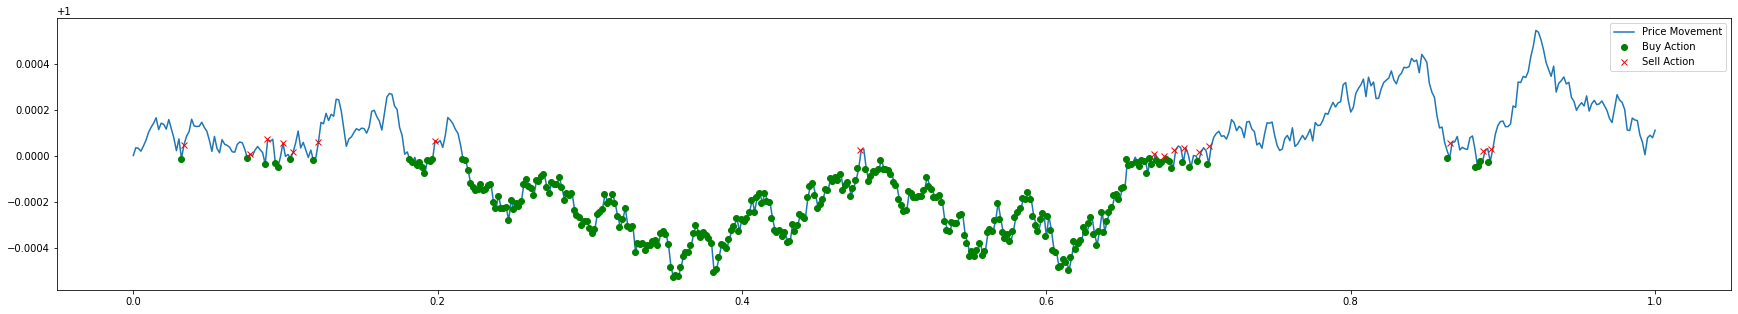

In [57]:
fig = plt.figure(figsize=(30,5))
plt.plot(t,X[4500])
plt.plot(buy_time, buy_point, 'o', color='green')
plt.plot(sell_time, sell_point, 'x', color='red');
plt.legend(["Price Movement","Buy Action","Sell Action"])
#print(mark)
plt.show()

In [ ]:
t_in_ms = [i for i in range(len(test_rewards))]
plt.plot(t_in_ms, test_rewards, linewidth=1)

In [ ]:
print(test_profits)

0.002593574841207369


In [19]:
#Try all sample path
samplepath_number = []
test_profits = []
for i in range(5001,len(X)):
  test_data = {'Time': t, 
        'X': X[i]}
  # Convert the dictionary into DataFrame 
  test_data = pd.DataFrame(test_data) 
  test_env = Environment1(test_data)
  pobs = test_env.reset()
  test_acts = []
  test_rewards = []
  print("Percentage done: ", i*100/len(X))
  for _ in range(len(test_env.data)-1):
      
      pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
      pact = np.argmax(pact.data)
      test_acts.append(pact.item())
      #print(pact.numpy())        
      obs, reward, done = test_env.step(pact.numpy())
      test_rewards.append(reward)

      pobs = obs
          
  test_profits.append(test_env.profits)
  samplepath_number.append(i+1)




Percentage done:  33.36666666666667
Percentage done:  33.4
Percentage done:  33.43333333333333
Percentage done:  33.46666666666667
Percentage done:  33.5
Percentage done:  33.53333333333333
Percentage done:  33.56666666666667
Percentage done:  33.6
Percentage done:  33.63333333333333
Percentage done:  33.666666666666664
Percentage done:  33.7
Percentage done:  33.733333333333334
Percentage done:  33.766666666666666
Percentage done:  33.8
Percentage done:  33.833333333333336
Percentage done:  33.86666666666667
Percentage done:  33.9
Percentage done:  33.93333333333333
Percentage done:  33.96666666666667
Percentage done:  34.0
Percentage done:  34.03333333333333
Percentage done:  34.06666666666667
Percentage done:  34.1
Percentage done:  34.13333333333333
Percentage done:  34.166666666666664
Percentage done:  34.2
Percentage done:  34.233333333333334
Percentage done:  34.266666666666666
Percentage done:  34.3
Percentage done:  34.333333333333336
Percentage done:  34.36666666666667
Percen

(array([  1.,   0.,   1.,   1.,   4.,   2.,  20.,  15.,  35.,  99., 935.,
        294., 240., 153., 105.,  56.,  16.,  11.,   6.,   5.]),
 array([-0.00723208, -0.00655878, -0.00588549, -0.0052122 , -0.00453891,
        -0.00386561, -0.00319232, -0.00251903, -0.00184573, -0.00117244,
        -0.00049915,  0.00017415,  0.00084744,  0.00152073,  0.00219402,
         0.00286732,  0.00354061,  0.0042139 ,  0.0048872 ,  0.00556049,
         0.00623378]),
 <a list of 20 Patch objects>)

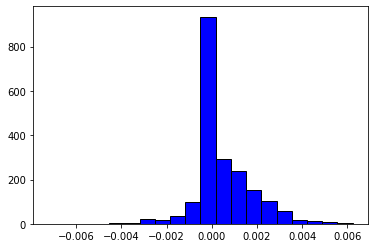

In [20]:
plt.hist(test_profits, color = 'blue', edgecolor = 'black',
         bins = 20)

In [21]:
YEAH = 0
NOOOO = 0
for elem in test_profits:
  if elem >= 0.0:
    YEAH += 1
  else:
    NOOOO -= 1

print("Percentage of Profitting: ", YEAH*100/(len(test_profits)),"%")

Percentage of Profitting:  84.7423711855928 %
